# Loading the data

In [57]:
import pandas as pd
import numpy as np

import torch
from sklearn.model_selection import train_test_split
from torch import nn
from sklearn.calibration import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import ConfusionMatrixDisplay

# set seed 
seed = 0
torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [58]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_encoded.csv', sep='|')

In [59]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Columns: 735 entries, num__budget to category
dtypes: float64(734), object(1)
memory usage: 49.3+ MB
None
   num__budget  num__revenue  num__popularity  num__runtime  num__vote_count  \
0     4.757463      1.005269         0.425819      0.448734         1.716450   
1     2.894642      1.159981         0.366180     -0.230573         1.636140   
2     3.826052      2.100421         0.503760      0.739865         1.420090   
3     2.628524      0.670763         0.183190     -0.230573         1.375134   
4     1.510832      0.743000         0.159881     -0.085007         0.961366   

   num__release_year  num__release_month  cat__original_language_ar  \
0           0.483259           -0.241059                        0.0   
1           0.605583           -0.533445                        0.0   
2           0.789068           -0.241059                        0.0   
3           0.727906            0.343713               

In [60]:
desired_order = ['bad', 'mediocre', 'good', 'great']
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(desired_order)
df['category'] = label_encoder.transform(df['category'])

# NN

In [61]:
X = df.drop('category', axis=1)
Y = df['category']

In [62]:
print(X.shape)

(8784, 734)


In [87]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [88]:
# Create a custom Dataset class
class MovieDataset(Dataset):
    def __init__(self, features, labels):
        # Convert features to a NumPy array if it's a DataFrame
        if isinstance(features, pd.DataFrame):
            features = features.to_numpy()  # Convert DataFrame to NumPy array
        
        self.X = torch.tensor(features, dtype=torch.float32)  # Convert features to tensor
        self.y = torch.tensor(labels, dtype=torch.long)       # Convert labels to tensor

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Assuming X_train and Y_train are your features and labels DataFrames
# Convert Y_train to a NumPy array if it's also a DataFrame
if isinstance(Y_train, pd.Series):
    Y_train = Y_train.to_numpy()

if isinstance(Y_test, pd.Series):
    Y_test = Y_test.to_numpy()

# Create Dataset objects
train_dataset = MovieDataset(X_train, Y_train)
test_dataset = MovieDataset(X_test, Y_test)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [89]:
# Define the neural network
class MovieClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MovieClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First hidden layer with 128 neurons
        self.fc2 = nn.Linear(128, 64)            # Third hidden layer with 32 neurons
        self.fc3 = nn.Linear(64, 16)            # Fourth hidden layer with 16 neurons
        self.output = nn.Linear(16, num_classes) # Output layer

        # Activation function
        self.relu = nn.ReLU()
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.output(x)  # Output layer (logits)
        return x
    

In [90]:
input_size = X_train.shape[1]  # Number of input features
num_classes = len(np.unique(Y_train))  # Number of classes in the target
model = MovieClassifier(input_size, num_classes)

# Set the device
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5, amsgrad=True, eps=1e-8) 

# Training loop
num_epochs = 50  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/50], Loss: 0.9122
Epoch [2/50], Loss: 0.6704
Epoch [3/50], Loss: 0.5668
Epoch [4/50], Loss: 0.7203
Epoch [5/50], Loss: 1.1046
Epoch [6/50], Loss: 0.6317
Epoch [7/50], Loss: 0.9129
Epoch [8/50], Loss: 0.6572
Epoch [9/50], Loss: 0.5992
Epoch [10/50], Loss: 0.5358
Epoch [11/50], Loss: 0.6884
Epoch [12/50], Loss: 0.5215
Epoch [13/50], Loss: 0.5069
Epoch [14/50], Loss: 0.6777
Epoch [15/50], Loss: 0.3294
Epoch [16/50], Loss: 0.2149
Epoch [17/50], Loss: 0.3709
Epoch [18/50], Loss: 0.2818
Epoch [19/50], Loss: 0.2755
Epoch [20/50], Loss: 0.1550
Epoch [21/50], Loss: 0.3332
Epoch [22/50], Loss: 0.3703
Epoch [23/50], Loss: 0.4449
Epoch [24/50], Loss: 0.1792
Epoch [25/50], Loss: 0.1503
Epoch [26/50], Loss: 0.2446
Epoch [27/50], Loss: 0.4751
Epoch [28/50], Loss: 0.3652
Epoch [29/50], Loss: 0.0670
Epoch [30/50], Loss: 0.1031
Epoch [31/50], Loss: 0.2802
Epoch [32/50], Loss: 0.2563
Epoch [33/50], Loss: 0.1705
Epoch [34/50], Loss: 0.2037
Epoch [35/50], Loss: 0.2313
Epoch [36/50], Loss: 0.0807
E

In [82]:
# Print confusion matrix
from sklearn.metrics import confusion_matrix

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
        y_true += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()



In [83]:
# Print accuracy of the model
from sklearn.metrics import accuracy_score
y_true = np.array(y_true)
y_pred = np.array(y_pred)
accuracy_score(y_true, y_pred)

0.6647694934547524

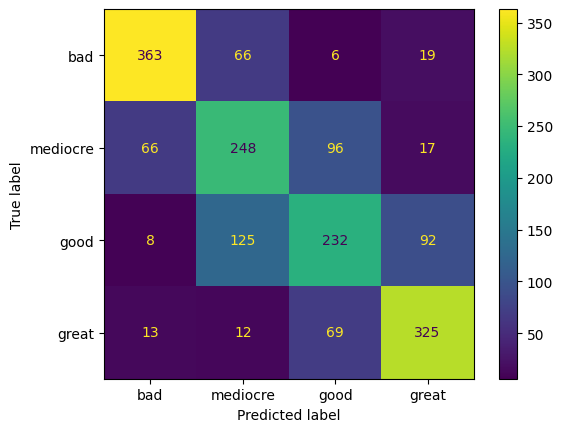

In [84]:
# Print confusion matrix for the model
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()

In [85]:
from sklearn.tree import DecisionTreeClassifier, export_text


surrogate_model = DecisionTreeClassifier(max_depth=10)  # Control complexity with max_depth
surrogate_model.fit(X_test, y_pred)

# Print the rules
tree_rules = export_text(surrogate_model, feature_names=df.columns[:-1].tolist())
print(tree_rules)

|--- num__vote_count <= -0.46
|   |--- num__runtime <= -0.06
|   |   |--- num__release_year <= -2.88
|   |   |   |--- class: 3
|   |   |--- num__release_year >  -2.88
|   |   |   |--- genres__documentary <= 0.50
|   |   |   |   |--- production_countries__america <= 0.50
|   |   |   |   |   |--- num__release_year <= -0.83
|   |   |   |   |   |   |--- num__vote_count <= -0.54
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- num__vote_count >  -0.54
|   |   |   |   |   |   |   |--- genres__horror <= 0.50
|   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |--- genres__horror >  0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- num__release_year >  -0.83
|   |   |   |   |   |   |--- num__runtime <= -1.23
|   |   |   |   |   |   |   |--- production_countries__japan <= 0.50
|   |   |   |   |   |   |   |   |--- num__revenue <= -0.35
|   |   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |   |--- num__

# Feature importances on DL

In [100]:
def train_and_evaluate(X_train, Y_train, X_test, Y_test, num_epochs=10):
    input_size = X_train.shape[1]  # Number of input features
    model = MovieClassifier(input_size, num_classes)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5, amsgrad=True, eps=1e-8)

    # Create data loaders for training
    train_tensor = torch.FloatTensor(X_train.to_numpy())
    train_labels_tensor = torch.LongTensor(Y_train)
    train_dataset = torch.utils.data.TensorDataset(train_tensor, train_labels_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate on the test set
    model.eval()
    test_tensor = torch.FloatTensor(X_test.to_numpy())
    test_labels_tensor = torch.LongTensor(Y_test)
    test_dataset = torch.utils.data.TensorDataset(test_tensor, test_labels_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    y_pred = []
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            y_pred += predicted.cpu().numpy().tolist()

    return accuracy_score(Y_test, y_pred)

In [102]:

# Calculate baseline accuracy

baseline_accuracy = train_and_evaluate(X_train, Y_train, X_test, Y_test)
print(f'Baseline Accuracy: {baseline_accuracy:.4f}')

# Feature importance calculation
importances = {}

# Drop features that start with 'num' or 'cat' one at a time
for feature in X.columns:
    if feature.startswith('num') or feature.startswith('cat'):
        X_train_dropped = X_train.drop(feature, axis=1)
        X_test_dropped = X_test.drop(feature, axis=1)
        
        accuracy_dropped = train_and_evaluate(X_train_dropped, Y_train, X_test_dropped, Y_test)
        importances[feature] = baseline_accuracy - accuracy_dropped  # Importance is the drop in accuracy


groups = ['cast', 'director', 'production_companies', 'title', 'overview', 'tagline', 'production_countries', 'genres']

# Drop features one group at a time
for group in groups:
    features_to_drop = [feature for feature in X.columns if feature.startswith(group)]
    X_train_dropped = X_train.drop(features_to_drop, axis=1)
    X_test_dropped = X_test.drop(features_to_drop, axis=1)

    accuracy_dropped = train_and_evaluate(X_train_dropped, Y_train, X_test_dropped, Y_test)
    importances[group] = baseline_accuracy - accuracy_dropped  # Importance is the drop in accuracy

# Convert to a more interpretable format (e.g., DataFrame)
import pandas as pd
importance_df = pd.DataFrame(importances.items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


Baseline Accuracy: 0.6727
                      Feature  Importance
4             num__vote_count    0.057484
53                     genres    0.027888
5           num__release_year    0.022766
41  cat__original_language_th    0.013660
25  cat__original_language_it    0.012521
2             num__popularity    0.012521
42  cat__original_language_tr    0.010814
1                num__revenue    0.007968
29  cat__original_language_mk    0.007399
22  cat__original_language_hi    0.006261
3                num__runtime    0.005692
28  cat__original_language_la    0.005692
34  cat__original_language_pt    0.005692
13  cat__original_language_de    0.005692
33  cat__original_language_pl    0.004553
32  cat__original_language_no    0.003415
12  cat__original_language_da    0.002846
30  cat__original_language_nb    0.002846
9   cat__original_language_bs    0.002846
48       production_companies    0.002846
7   cat__original_language_ar    0.002277
43  cat__original_language_uk    0.001707
8   cat_

In [103]:
# Drop columns with negative importance if they exist
columns_to_drop = importance_df[importance_df['Importance'] < 0]['Feature'].tolist()
X_columns = X.columns.tolist()
# keep columns that are not in columns_to_drop or that dont start with a column to drop
columns_to_keep = [col for col in X_columns if col not in columns_to_drop and not any(col.startswith(drop_col) for drop_col in columns_to_drop)]
X_train_filtered = X_train[columns_to_keep]
X_test_filtered = X_test[columns_to_keep]

In [104]:
train_and_evaluate(X_train_filtered, Y_train, X_test_filtered, Y_test, 50)

0.7142857142857143